## Imports

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Activation, Flatten, MaxPooling1D
from tensorflow.keras.layers import Conv1D, Dense
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from kerastuner import HyperModel
from kerastuner.tuners import Hyperband
from kerastuner.tuners import RandomSearch
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import pickle
import time

### Enables Tensorflow to use the GPU

In [2]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
   tf.config.experimental.set_memory_growth(physical_devices[0], True)

## Paths

In [3]:
paths = {"pickels": "../../assets/audio_sentiment_data_v2/pickles",
         "models": "../../assets/audio_sentiment_data_v2/models",
         "tuners": "../../assets/audio_sentiment_data_v2/tuners"}

## Loading in the data splits from the pickels

In [4]:
pickle_in = open(f"{paths['pickels']}/X_train_19_april.pickle","rb")
X_train = pickle.load(pickle_in)

pickle_in = open(f"{paths['pickels']}/X_val_19_april.pickle","rb")
X_val = pickle.load(pickle_in)

pickle_in = open(f"{paths['pickels']}/X_test_19_april.pickle","rb")
X_test = pickle.load(pickle_in)

pickle_in = open(f"{paths['pickels']}/y_train_19_april.pickle","rb")
y_train = pickle.load(pickle_in)

pickle_in = open(f"{paths['pickels']}/y_val_19_april.pickle","rb")
y_val = pickle.load(pickle_in)

pickle_in = open(f"{paths['pickels']}/y_test_19_april.pickle","rb")
y_test = pickle.load(pickle_in)

pickle_in = open(f"{paths['pickels']}/labels_19_april.pickle","rb")
lb= pickle.load(pickle_in)
labels = lb.classes_

## Defining the Model using HyperModel Class to perform hyperparameters tuning

In [5]:
class CNNHyperModel(HyperModel):
    
    def __init__(self, input_shape, num_classes):
        self.input_shape = input_shape
        self.num_classes = num_classes
        
    def build(self, hp):
        model = Sequential()
        
        model.add(
                Dense(
                    units=hp.Int(
                        'dense_units_0',
                        min_value=32,
                        max_value=512,
                        step=32,
                        default=32
                    ),
                    activation='relu',
                    input_shape=self.input_shape
                )
            )
        
        model.add(
                Dropout(rate=hp.Float(
                    f'dropout_0',
                    min_value=0.0,
                    max_value=0.5,
                    default=0.25,
                    step=0.05,
                ))
            )
        
        for i in range(hp.Int('num_layers', 0, 5)):
            model.add(
                Dense(
                    units=hp.Int(
                        f'dense_units_{i+1}',
                        min_value=32,
                        max_value=512,
                        step=32,
                        default=32
                    ),
                    activation='relu'
                )
            )

            model.add(
                Dropout(rate=hp.Float(
                    f'dropout_{i+1}',
                    min_value=0.0,
                    max_value=0.5,
                    default=0.25,
                    step=0.05,
                ))
            )
        
        model.add(Dense(self.num_classes, activation='softmax'))
        

        model.compile(
            optimizer=tf.keras.optimizers.RMSprop(
                hp.Float(
                    'learning_rate',
                    min_value=1e-4,
                    max_value=1e-2,
                    sampling='LOG',
                    default=1e-3
                )
            ),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
        return model       

---

# Hyperband Tuning


## Creating an instance of the HyperModel Class

In [6]:
NUM_CLASSES = 4
INPUT_SHAPE = (37,)

hypermodel = CNNHyperModel(input_shape=INPUT_SHAPE,
                           num_classes=NUM_CLASSES)

## Defining the Hyperband Tuner

In [7]:
SEED = 42

hb_tuner = Hyperband(
    hypermodel,
    objective='val_accuracy',
    max_epochs=40,
    hyperband_iterations=2,
    seed=SEED,
    directory=f'{paths["tuners"]}/hyperband_tuner',
    project_name='AudioSentimentClassifier19April'
)

### Searching for the best model

In [8]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

hb_tuner.search(X_train,
                y_train,
                validation_data=(X_val, y_val),
                epochs=40,
                callbacks=[stop_early]
               )

Trial 180 Complete [00h 00m 07s]
val_accuracy: 0.8779220581054688

Best val_accuracy So Far: 0.9220778942108154
Total elapsed time: 00h 13m 24s
INFO:tensorflow:Oracle triggered exit


### Retrieving the best model

In [9]:
best_hb_model = hb_tuner.get_best_models(num_models=1)[0]
best_hb_hps = hb_tuner.get_best_hyperparameters(num_trials=1)[0]
best_hb_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 320)               12160     
_________________________________________________________________
dropout (Dropout)            (None, 320)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 224)               71904     
_________________________________________________________________
dropout_1 (Dropout)          (None, 224)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               115200    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 416)               2

In [10]:
best_hb_model.evaluate(X_test, y_test)

9/9 [==============================] - 0s 3ms/step - loss: 0.2902 - accuracy: 0.8735


[0.2953105568885803, 0.8643410801887512]

### Training a model on the best hyperparameters

In [29]:
hb_model = hb_tuner.hypermodel.build(best_hb_hps)

In [30]:
hb_history = hb_model.fit(X_train, y_train, epochs=15, validation_data=(X_val, y_val), verbose=2)

Epoch 1/15
61/61 - 1s - loss: 0.7176 - accuracy: 0.7024 - val_loss: 0.4738 - val_accuracy: 0.8026
Epoch 2/15
61/61 - 0s - loss: 0.4173 - accuracy: 0.8300 - val_loss: 0.3955 - val_accuracy: 0.8208
Epoch 3/15
61/61 - 0s - loss: 0.3664 - accuracy: 0.8419 - val_loss: 0.4146 - val_accuracy: 0.8286
Epoch 4/15
61/61 - 0s - loss: 0.3279 - accuracy: 0.8543 - val_loss: 0.3561 - val_accuracy: 0.8312
Epoch 5/15
61/61 - 0s - loss: 0.2957 - accuracy: 0.8740 - val_loss: 0.2973 - val_accuracy: 0.8571
Epoch 6/15
61/61 - 0s - loss: 0.2751 - accuracy: 0.8870 - val_loss: 0.3870 - val_accuracy: 0.8312
Epoch 7/15
61/61 - 0s - loss: 0.2611 - accuracy: 0.8870 - val_loss: 0.3544 - val_accuracy: 0.8286
Epoch 8/15
61/61 - 0s - loss: 0.2491 - accuracy: 0.8963 - val_loss: 0.3125 - val_accuracy: 0.8675
Epoch 9/15
61/61 - 0s - loss: 0.2248 - accuracy: 0.9067 - val_loss: 0.2956 - val_accuracy: 0.8805
Epoch 10/15
61/61 - 0s - loss: 0.2144 - accuracy: 0.9119 - val_loss: 0.3099 - val_accuracy: 0.8519
Epoch 11/15
61/61 -

### Plotting Loss and Accuracy graphs

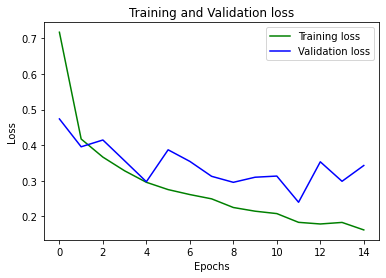

In [31]:
train_loss = hb_history.history['loss']
val_loss = hb_history.history['val_loss']

plt.plot(train_loss, 'g', label='Training loss')
plt.plot(val_loss, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

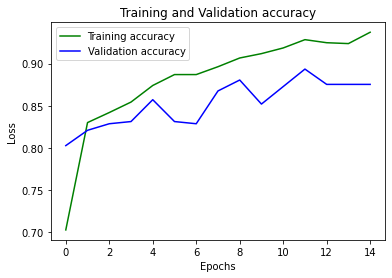

In [32]:
train_acc = hb_history.history['accuracy']
val_acc = hb_history.history['val_accuracy']

plt.plot(train_acc, 'g', label='Training accuracy')
plt.plot(val_acc, 'b', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Evaluating the tuned model

In [33]:
test_accuracy = hb_model.evaluate(X_test, y_test)

9/9 [==============================] - 0s 3ms/step - loss: 0.3624 - accuracy: 0.8721


### Classification report

In [34]:
predictions = hb_model.predict(X_test)
predictions = np.argmax(predictions, axis=1)

new_y_test = np.argmax(y_test, axis=1)

print(classification_report(new_y_test, predictions))

              precision    recall  f1-score   support

           0       0.78      1.00      0.87        62
           1       0.94      0.78      0.85        59
           2       0.89      0.95      0.92        66
           3       0.93      0.76      0.84        71

    accuracy                           0.87       258
   macro avg       0.88      0.87      0.87       258
weighted avg       0.88      0.87      0.87       258



### Confusion matrix

<AxesSubplot:xlabel='Predicted', ylabel='Actual'>

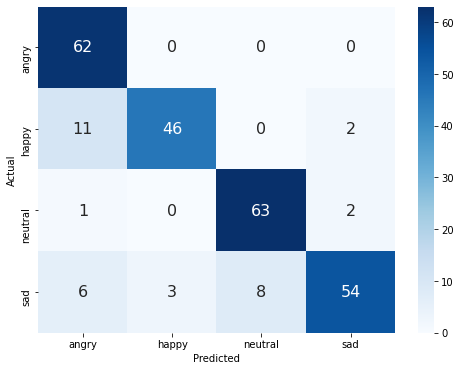

In [35]:
%matplotlib inline
conf_matrix = pd.DataFrame(tf.math.confusion_matrix(new_y_test, predictions).numpy(), index=labels, columns=labels)
conf_matrix.index.name = 'Actual'
conf_matrix.columns.name = 'Predicted'
fig_dims = (8, 6)
fig, ax = plt.subplots(figsize=fig_dims)
sns.heatmap(conf_matrix, annot=True, cmap="Blues", annot_kws={"size": 16}, fmt='d')

### Saving the tuned model

In [36]:
name = f"hyperband_tuned_model_19_april_{test_accuracy}"
filepath = f"{paths['models']}/{name}"
hb_model.save(filepath)

INFO:tensorflow:Assets written to: ../../assets/audio_sentiment_data_v2/models/hyperband_tuned_model_19_april_[0.3624165654182434, 0.8720930218696594]\assets


---

# Random Search Tuning


## Creating an instance of the HyperModel Class

In [ ]:
NUM_CLASSES = 5
INPUT_SHAPE = (37,)

hypermodel = CNNHyperModel(input_shape=INPUT_SHAPE,
                           num_classes=NUM_CLASSES)

## Defining the RandomSearch Tuner

In [ ]:
SEED = 42

rs_tuner = RandomSearch(
    hypermodel,
    objective='val_accuracy',
    max_trials=50,
    executions_per_trial=2,
    directory=f'{paths["tuners"]}/random_search_tuner',
    project_name='AudioSentimentClassifier'
)

### Searching for the best model

In [ ]:
rs_tuner.search(X_train,
                y_train,
                validation_data=(X_val, y_val),
                epochs=30)

### Retrieving the best model

In [ ]:
best_model = rs_tuner.get_best_models(num_models=1)[0]
best_hps = rs_tuner.get_best_hyperparameters(num_trials=1)[0]
best_model.summary()

In [ ]:
best_model.evaluate(X_test, y_test)

### Training a model on the best hyperparameters

In [ ]:
model = rs_tuner.hypermodel.build(best_hps)

In [ ]:
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val), verbose=2)

### Plotting Loss and Accuracy graphs

In [ ]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(train_loss, 'g', label='Training loss')
plt.plot(val_loss, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(train_acc, 'g', label='Training accuracy')
plt.plot(val_acc, 'b', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Evaluating the tuned model

In [ ]:
test = model.evaluate(X_test, y_test)

### Classification report

In [ ]:
predictions = model.predict(X_test)
predictions = np.argmax(predictions, axis=1)

new_y_test = np.argmax(y_test, axis=1)

print(classification_report(new_y_test, predictions))

### Confusion matrix

In [ ]:
%matplotlib inline
conf_matrix = pd.DataFrame(tf.math.confusion_matrix(new_y_test, predictions).numpy(), index=labels, columns=labels)
conf_matrix.index.name = 'Actual'
conf_matrix.columns.name = 'Predicted'
fig_dims = (8, 6)
fig, ax = plt.subplots(figsize=fig_dims)
sns.heatmap(conf_matrix, annot=True, cmap="Blues", annot_kws={"size": 16}, fmt='d')

### Saving the tuned model

In [ ]:
name = f"random_search_tuned_best_model_{test}"
filepath = f"{paths['models']}/{name}"
model.save(filepath)

# 

In [ ]:
model_name = "random_search_tuned_best_model_[0.3875276744365692, 0.8404908180236816]"
model = tf.keras.models.load_model(f"{paths['models']}/{model_name}")

In [ ]:
model.get_config()